In [79]:
%store -r Final_Data_Set_Nor
%store -r EN_Des

import dgl
import numpy as np
import networkx as nx
import torch as T
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv
from dgl.nn import SAGEConv
import dgl.nn
import itertools
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from torch.autograd import Variable
from ipykernel import kernelapp as app

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import time
import seaborn as sns
import matplotlib.patheffects as PathEffects
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,rc={"lines.linewidth": 2.5})

import nbimporter
from NDE_Time_Series_Problem import fashion_scatter

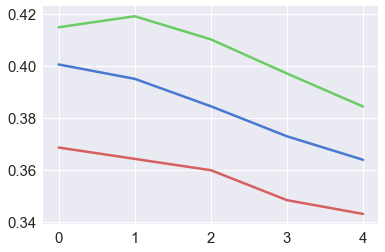

In [2]:
sector_rev_3 = np.array([0.,0.,0.,0.,0.])
sector_rev_2 = np.array([0.,0.,0.,0.,0.])
sector_rev_5 = np.array([0.,0.,0.,0.,0.])
n = 0
m = 0
p = 0
for i in Final_Data_Set_Nor.items():
    ID, data = i
    if data['Sector'][1:-1] == "325412":
        sector_rev_3 += np.array(data['Revenue'])
        n += 1
    elif data['Sector'][1:-1] == "2111":
        sector_rev_2 += np.array(data['Revenue'])
        m += 1
    elif data['Sector'][1:-1] == "511210":
        sector_rev_5 += np.array(data['Revenue'])
        p += 1
    
        
sector_rev_3 = sector_rev_3/n
sector_rev_2 = sector_rev_2/m
sector_rev_5 = sector_rev_5/p
plt.plot(range(len(sector_rev_3)),sector_rev_3)
plt.plot(range(len(sector_rev_2)),sector_rev_2)
plt.plot(range(len(sector_rev_5)),sector_rev_5)
plt.show()

In [138]:
def build_borrower_sector_graph(Data_Set):
    
    n_borrowers = len(Data_Set.keys())
    
    sector_list = set()
    for i in Data_Set.items():
        ID,data = i
        sector_list.add(data['Sector'])
    print(sector_list)
    sector_list = list(sector_list)
    n_sectors = len(sector_list)
    
    b_s_dst = []
    for i in Data_Set.items():
        ID,data = i
        b_s_dst.append(sector_list.index(data['Sector']))
    
    b_s_src = T.arange(n_borrowers)
    b_s_dst = T.tensor(b_s_dst)
    
    
    data_dict = {
    ('R&E', 'fin1', 'borrower' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
    ('NDE&TDE', 'fin2', 'borrower' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
    ('Description', 'text', 'borrower' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
        
    ('R', 'R_att', 'R&E' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
    ('E', 'E_att', 'R&E' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
    ('NDE', 'NDE_att', 'NDE&TDE' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
    ('TDE', 'TDE_att', 'NDE&TDE' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
    ('Att_Description', 'text_att', 'Description' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
        
    ('sector', 'belongs to', 'borrower'): (b_s_dst, b_s_src),
    ('Factor', 'effect', 'sector'): (T.tensor([0,1,2]), T.tensor([0,1,2]))
    }

    return dgl.heterograph(data_dict),n_borrowers,n_sectors, b_s_dst

G, n_borrowers, n_sectors, sector_list = build_borrower_sector_graph(Final_Data_Set_Nor)


{'"2111"', '"511210"', '"325412"'}


In [139]:
def Loss_Function(embeddings, target_centers, centers):
    
    next_target = []
    for i in range(len(embeddings)):

        cluster = target_centers[i]
        
        if len(centers) != 1: 
            dist = []
            C = []
            for m in centers:
                d = np.square(embeddings.detach().numpy()[i] - m.detach().numpy()).mean()
                dist.append(d)
                C.append(m)
                
            
            tup = list(zip(dist,C))
            lst = len(tup) 
            for i in range(0, lst): 

                for j in range(0, lst-i-1): 
                    if (tup[j][0] > tup[j + 1][0]): 
                        temp = tup[j] 
                        tup[j]= tup[j + 1] 
                        tup[j + 1]= temp
            
            next_c = tup[1][1]
        else:
            next_c = centers[0]
            
        
        next_target.append(next_c.detach().numpy())
    
    next_target = T.tensor(next_target)
    
    b = T.sqrt(T.sum((embeddings - next_target)**2,1))
    a = T.sqrt(T.sum((embeddings - target_centers)**2,1))
    
#     a = a/T.max(a)
#     b = b/T.max(b)
    
#     print("a ", T.sum(a))
#     print("b ", T.sum(b),'\n')
    
    return T.sum((a))            #T.sum((-b))                #/T.max(T.sum(a),T.sum(b))
    

In [187]:
class RGCN(nn.Module):
    def __init__(self, in_RE, out_RE, in_NT, out_NT, in_Des, out_Des, in_sector, out_sector, in_borrower, out_borrower, L1_names, L2_names, L3_names, L4_names, L5_names):
        super().__init__()

        self.conv1 = dgl.nn.HeteroGraphConv({rel: SAGEConv(in_sector, out_sector, 'mean',norm = None, activation = None, bias = False) for rel in L1_names}, aggregate='sum')
        self.conv2 = dgl.nn.HeteroGraphConv({rel: GraphConv(in_RE, out_RE, 'none', False, activation = None, bias = False) for rel in L2_names}, aggregate='sum')
        self.conv3 = dgl.nn.HeteroGraphConv({rel: GraphConv(in_NT, out_NT, 'none', False, activation = None, bias = False) for rel in L3_names}, aggregate='sum')
        self.conv4 = dgl.nn.HeteroGraphConv({rel: GraphConv(in_Des, out_Des, 'none', activation = None, bias = False) for rel in L4_names}, aggregate='sum')
        self.conv5 = dgl.nn.HeteroGraphConv({rel: SAGEConv(in_borrower, out_borrower, 'mean',norm = None, activation = None, bias = False) for rel in L5_names}, aggregate='sum')

    def forward(self, graph, inputs):
        sector_inputs = {'Factor' : inputs['Factor'], 'sector' : inputs['sector'], 'borrower' : inputs['borrower']}
        h_sector = self.conv1(graph, sector_inputs)
        #h_sector = {k: F.leaky_relu(v) for k, v in h_sector.items()}
        #print('Factor', inputs['Factor'],"\n","sector ", inputs['sector'],"\n","Output", h_sector)
        
        RE_inputs = {'R' : inputs['R'], 'E' : inputs['E'], 'R&E' : inputs['R&E'], 'borrower' : inputs['borrower']}
        h_RE = self.conv2(graph, RE_inputs)
        #h_RE = {k: F.leaky_relu(v) for k, v in h_RE.items()}
        print("R", inputs['R'],"E", inputs["E"],"R&E ", h_RE['R&E'])
        
        NT_inputs = {'NDE' : inputs['NDE'], 'TDE' : inputs['TDE'], 'NDE&TDE' : inputs['NDE&TDE'], 'borrower' : inputs['borrower']}
        h_NT = self.conv3(graph, NT_inputs)
        #h_NT = {k: F.leaky_relu(v) for k, v in h_NT.items()}
        #print("NDE&TDE Shape ", h_NT['NDE&TDE'].size())
        
        Des_inputs = {'Description' : inputs['Description'], 'Att_Description' : inputs['Att_Description'], 'borrower' : inputs['dummy_borrower']}
        h_Des = self.conv4(graph, Des_inputs)
        #h_Des = {k: F.leaky_relu(v) for k, v in h_Des.items()}
        #print("Description ", h_Des['Description'])
        
        #borrower_inputs = {'borrower' : inputs['borrower'], 'R&E' : h_RE['R&E'],'sector' : h_sector['sector'], 'NDE&TDE' : h_NT['NDE&TDE'], 'Description' : h_Des['Description']}
        #borrower_inputs = {'borrower' : inputs['borrower'], 'sector' : h_sector['sector']}
        #borrower_inputs = {'borrower' : inputs['borrower'], 'NDE&TDE' : h_NT['NDE&TDE']}
        borrower_inputs = {'borrower' : inputs['borrower'], 'R&E' : h_RE['R&E']}
        #borrower_inputs = {'borrower' : inputs['borrower'], 'Description' : h_Des['Description']}
        h_borrower = self.conv5(graph, borrower_inputs)
        
        return h_borrower
    


In [188]:
model = RGCN(5,5,5,5,768,5,5,5,5,5, ['belongs to','effect'],['R_att','E_att','fin1'],['NDE_att','TDE_att','fin2'],['text_att','text'],['belongs to','text','fin1','fin2'])

for i in Final_Data_Set_Nor.items():
    ID,data = i
    R_Att = T.tensor([data['Revenue']])
    E_Att = T.tensor([data['EBITDA']])
    NDE_Att = T.tensor([data['NDE']])
    TDE_Att = T.tensor([data['TDE']])
    Des_Att = T.tensor(data['Description Embedding'])
    break
    
for i in Final_Data_Set_Nor.items():
    ID,data = i
    R_Att = T.cat((T.tensor([data['Revenue']]),R_Att),0)
    E_Att = T.cat((T.tensor([data['EBITDA']]),E_Att),0)
    NDE_Att = T.cat((T.tensor([data['NDE']]),NDE_Att),0)
    TDE_Att = T.cat((T.tensor([data['TDE']]),TDE_Att),0)
    Des_Att = T.cat((T.tensor(data['Description Embedding']),Des_Att),0)

    
G.nodes['borrower'].data['f'] = T.ones(n_borrowers,5)
G.nodes['R'].data['f'] = R_Att[1:]
G.nodes['E'].data['f'] = E_Att[1:]
G.nodes['R&E'].data['f'] = T.ones(n_borrowers,5)
G.nodes['NDE'].data['f'] = NDE_Att[1:]
G.nodes['TDE'].data['f'] = TDE_Att[1:]
G.nodes['NDE&TDE'].data['f'] = T.ones(n_borrowers,5)
G.nodes['Att_Description'].data['f'] = Des_Att[1:]
G.nodes['Description'].data['f'] = T.ones(n_borrowers,768)
G.nodes['Factor'].data['f'] = T.ones(n_sectors,5)
G.nodes['sector'].data['f'] = T.tensor([[1.,0.,0.,0.,0.],[0.,0.,1.,0.,0.],[0.,0.,0.,0.,1.]])

In [189]:
borrower_feats = G.nodes['borrower'].data['f']
sector_feats = G.nodes['sector'].data['f']
R_feats = G.nodes['R'].data['f']
E_feats = G.nodes['E'].data['f']
RE_feats = G.nodes['R&E'].data['f']
NDE_feats = G.nodes['NDE'].data['f']
TDE_feats = G.nodes['TDE'].data['f']
NT_feats = G.nodes['NDE&TDE'].data['f']
Des_feats = G.nodes['Description'].data['f']
Des_att_feats = G.nodes['Att_Description'].data['f']
factor_feats = G.nodes['Factor'].data['f']
dummy_borrower_feats = T.ones(n_borrowers,768)

node_features = {'borrower':borrower_feats,'sector':sector_feats,'R':R_feats,'E':E_feats,'R&E':RE_feats,'NDE':NDE_feats,
                 'Description':Des_feats,'Att_Description':Des_att_feats,'TDE':TDE_feats,'NDE&TDE': NT_feats,
                 'Factor':factor_feats,'dummy_borrower' : dummy_borrower_feats}
opt = T.optim.Adam(model.parameters(),lr=0.01)

clusters = 3
Loss = []
epochs = 100
index = [i for i, n in enumerate(sector_list) if n == 0]
index2 = [i for i, n in enumerate(sector_list) if n == 1]
index3 = [i for i, n in enumerate(sector_list) if n == 2]

for epoch in range(epochs):
    
    model.train()
    logits = model(G, node_features)
    
    X = logits['borrower'].detach().numpy()

    #X = X[index]
    training_kmeans = KMeans(n_clusters=clusters, random_state=0).fit(X)
    centers = training_kmeans.cluster_centers_
    
    target_centers = []
    for i in X:
        l = []
        for j in centers:
            mse = np.square(i - j).mean()
            l.append(mse)
        
        target_centers.append(l.index(min(l)))
        
        
    centers = T.tensor(centers)
    target_centers = centers[T.tensor(target_centers)]
    

    score = Loss_Function(logits['borrower'], target_centers, centers)
    Loss.append(score.tolist())

    
    opt.zero_grad()
    score.backward()
    opt.step()



R tensor([[0.3000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.3000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.4000],
        ...,
        [0.6000, 0.6000, 0.6000, 0.6000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000]]) E tensor([[0.1000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.2000, 0.3000, 0.3000, 0.3000, 0.2000],
        ...,
        [0.5000, 0.6000, 0.6000, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]) R&E  tensor([[0.4000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.5000, 0.6000, 0.6000, 0.6000, 0.6000],
        [0.7000, 0.8000, 0.8000, 0.8000, 0.6000],
        ...,
        [1.1000, 1.2000, 1.2000, 1.1000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000]])
R tensor([[0.3000, 0.3000, 0.3000, 0.3000, 0.3000

R tensor([[0.3000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.3000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.4000],
        ...,
        [0.6000, 0.6000, 0.6000, 0.6000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000]]) E tensor([[0.1000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.2000, 0.3000, 0.3000, 0.3000, 0.2000],
        ...,
        [0.5000, 0.6000, 0.6000, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]) R&E  tensor([[0.4000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.5000, 0.6000, 0.6000, 0.6000, 0.6000],
        [0.7000, 0.8000, 0.8000, 0.8000, 0.6000],
        ...,
        [1.1000, 1.2000, 1.2000, 1.1000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000]])
R tensor([[0.3000, 0.3000, 0.3000, 0.3000, 0.3000

R tensor([[0.3000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.3000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.4000],
        ...,
        [0.6000, 0.6000, 0.6000, 0.6000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000]]) E tensor([[0.1000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.2000, 0.3000, 0.3000, 0.3000, 0.2000],
        ...,
        [0.5000, 0.6000, 0.6000, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]) R&E  tensor([[0.4000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.5000, 0.6000, 0.6000, 0.6000, 0.6000],
        [0.7000, 0.8000, 0.8000, 0.8000, 0.6000],
        ...,
        [1.1000, 1.2000, 1.2000, 1.1000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000]])
R tensor([[0.3000, 0.3000, 0.3000, 0.3000, 0.3000

R tensor([[0.3000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.3000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.4000],
        ...,
        [0.6000, 0.6000, 0.6000, 0.6000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000]]) E tensor([[0.1000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.2000, 0.3000, 0.3000, 0.3000, 0.2000],
        ...,
        [0.5000, 0.6000, 0.6000, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]) R&E  tensor([[0.4000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.5000, 0.6000, 0.6000, 0.6000, 0.6000],
        [0.7000, 0.8000, 0.8000, 0.8000, 0.6000],
        ...,
        [1.1000, 1.2000, 1.2000, 1.1000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000]])
R tensor([[0.3000, 0.3000, 0.3000, 0.3000, 0.3000

R tensor([[0.3000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.3000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.4000],
        ...,
        [0.6000, 0.6000, 0.6000, 0.6000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000]]) E tensor([[0.1000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.2000, 0.3000, 0.3000, 0.3000, 0.2000],
        ...,
        [0.5000, 0.6000, 0.6000, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]) R&E  tensor([[0.4000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.5000, 0.6000, 0.6000, 0.6000, 0.6000],
        [0.7000, 0.8000, 0.8000, 0.8000, 0.6000],
        ...,
        [1.1000, 1.2000, 1.2000, 1.1000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000]])
R tensor([[0.3000, 0.3000, 0.3000, 0.3000, 0.3000

R tensor([[0.3000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.3000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.4000],
        ...,
        [0.6000, 0.6000, 0.6000, 0.6000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000]]) E tensor([[0.1000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.2000, 0.3000, 0.3000, 0.3000, 0.2000],
        ...,
        [0.5000, 0.6000, 0.6000, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]) R&E  tensor([[0.4000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.5000, 0.6000, 0.6000, 0.6000, 0.6000],
        [0.7000, 0.8000, 0.8000, 0.8000, 0.6000],
        ...,
        [1.1000, 1.2000, 1.2000, 1.1000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000]])
R tensor([[0.3000, 0.3000, 0.3000, 0.3000, 0.3000

R tensor([[0.3000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.3000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.4000],
        ...,
        [0.6000, 0.6000, 0.6000, 0.6000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000]]) E tensor([[0.1000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.2000, 0.3000, 0.3000, 0.3000, 0.2000],
        ...,
        [0.5000, 0.6000, 0.6000, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]) R&E  tensor([[0.4000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.5000, 0.6000, 0.6000, 0.6000, 0.6000],
        [0.7000, 0.8000, 0.8000, 0.8000, 0.6000],
        ...,
        [1.1000, 1.2000, 1.2000, 1.1000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000]])
R tensor([[0.3000, 0.3000, 0.3000, 0.3000, 0.3000

R tensor([[0.3000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.3000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.4000],
        ...,
        [0.6000, 0.6000, 0.6000, 0.6000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000]]) E tensor([[0.1000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.2000, 0.3000, 0.3000, 0.3000, 0.2000],
        ...,
        [0.5000, 0.6000, 0.6000, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]) R&E  tensor([[0.4000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.5000, 0.6000, 0.6000, 0.6000, 0.6000],
        [0.7000, 0.8000, 0.8000, 0.8000, 0.6000],
        ...,
        [1.1000, 1.2000, 1.2000, 1.1000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000]])
R tensor([[0.3000, 0.3000, 0.3000, 0.3000, 0.3000

R tensor([[0.3000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.3000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.4000],
        ...,
        [0.6000, 0.6000, 0.6000, 0.6000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000]]) E tensor([[0.1000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.2000, 0.3000, 0.3000, 0.3000, 0.2000],
        ...,
        [0.5000, 0.6000, 0.6000, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]) R&E  tensor([[0.4000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.5000, 0.6000, 0.6000, 0.6000, 0.6000],
        [0.7000, 0.8000, 0.8000, 0.8000, 0.6000],
        ...,
        [1.1000, 1.2000, 1.2000, 1.1000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000]])
R tensor([[0.3000, 0.3000, 0.3000, 0.3000, 0.3000

R tensor([[0.3000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.3000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.4000],
        ...,
        [0.6000, 0.6000, 0.6000, 0.6000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000]]) E tensor([[0.1000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.2000, 0.3000, 0.3000, 0.3000, 0.2000],
        ...,
        [0.5000, 0.6000, 0.6000, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]) R&E  tensor([[0.4000, 0.3000, 0.3000, 0.3000, 0.3000],
        [0.5000, 0.6000, 0.6000, 0.6000, 0.6000],
        [0.7000, 0.8000, 0.8000, 0.8000, 0.6000],
        ...,
        [1.1000, 1.2000, 1.2000, 1.1000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000]])
R tensor([[0.3000, 0.3000, 0.3000, 0.3000, 0.3000

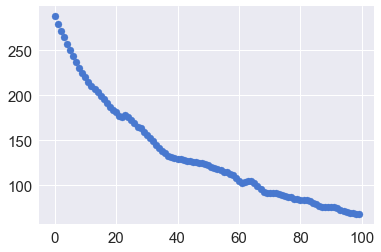

In [190]:
plt.scatter(list(range(len(Loss))),Loss)
plt.show()

# fashion_tsne = TSNE(random_state=123).fit_transform(X)
# fashion_scatter(fashion_tsne, kmeans.labels_)

In [191]:
def Print_Cluster(clusters,kmeans_labels):
    
    for i in range(clusters):

        cluster = np.where(kmeans_labels == i)[0]

        n = 0
        N = 0
        if len(cluster) < 5:
            l_N = len(cluster)
        else:
            l_N = 5
            
        print("Cluster ",i)
        for i in Final_Data_Set_Nor.items():
            ID,data = i

            if (n in cluster) and (N <= l_N):
                print(data['Revenue'],data['EBITDA'])#,data['Revenue'],data['EBITDA'])#data['NDE'],data['TDE'],'\n')#EN_Des[ID]['Description'],"\n")
                N += 1
            elif N > l_N:
                print("\n")
                break
            n += 1

Print_Cluster(clusters,training_kmeans.labels_)

Cluster  0
[0.5, 0.5, 0.5, 0.5, 0.5] [0, 0, 0, 0, 0]
[0.5, 0.5, 0.7, 0.5, 0.5] [0, 0, 0.6, 0, 0]
[0.1, 0.1, 0.1, 0.1, 0.1] [0.1, 0.1, 0, 0, 0]
[0.2, 0.2, 0.1, 0.1, 0.1] [0, 0, 0, 0, 0]
[0.2, 0.4, 0.3, 0.3, 0.1] [0, 0, 0.1, 0, 0]
[0.3, 0.3, 0.3, 0.3, 0.3] [0.1, 0.1, 0.1, 0.1, 0.1]


Cluster  1
[0.3, 0.3, 0.3, 0.3, 0.3] [0.1, 0.1, 0.1, 0.2, 0.1]
[0.1, 0.1, 0.1, 0.1, 0.1] [0, 0, 0, 0, 0]
[0.3, 0.3, 0.3, 0.3, 0.3] [0.3, 0.2, 0.2, 0.3, 0.3]
[0.7, 0.6, 0.5, 0.5, 0.6] [0.6, 0.5, 0.5, 0.5, 0.6]
[0.7, 0.7, 0.7, 0.7, 0.7] [0.5, 0.5, 0.5, 0.5, 0.5]
[0.1, 0.1, 0.1, 0.1, 0.1] [0, 0.1, 0.1, 0, 0]


Cluster  2
[0.6, 0.6, 0.6, 0.6, 0.5] [0.5, 0.6, 0.6, 0.5, 0]
[0.5, 0.5, 0.5, 0.4, 0.4] [0.1, 0.3, 0.1, 0, 0]
[0.5, 0.4, 0.3, 0.2, 0.2] [0, 0, 0, 0, 0]
[0.5, 0.5, 0.4, 0.3, 0.3] [0.5, 0.5, 0.3, 0.3, 0.3]
[0.5, 0.5, 0.5, 0.5, 0.5] [0, 0.3, 0, 0, 0.1]
[0.6, 0.7, 0.6, 0.6, 0.5] [0.5, 0.6, 0.5, 0.4, 0]




172 4 23


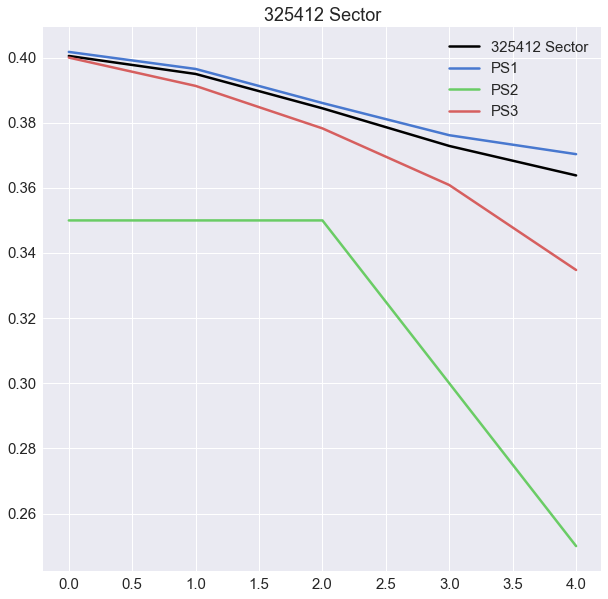

Avg Node Cluster Distance of Cluster  0  is  8.342858
Cluster  0  Center  [-2.7888162 -2.9798074]
Avg Node Cluster Distance of Cluster  1  is  0.0020971184
Cluster  1  Center  [10.65321  -6.882285]
Avg Node Cluster Distance of Cluster  2  is  1.5256912
Cluster  2  Center  [-1.3334594 12.058081 ]
1   13.99705
2   15.108148
0   13.99705
2   22.414675
0   15.108148
1   22.414675


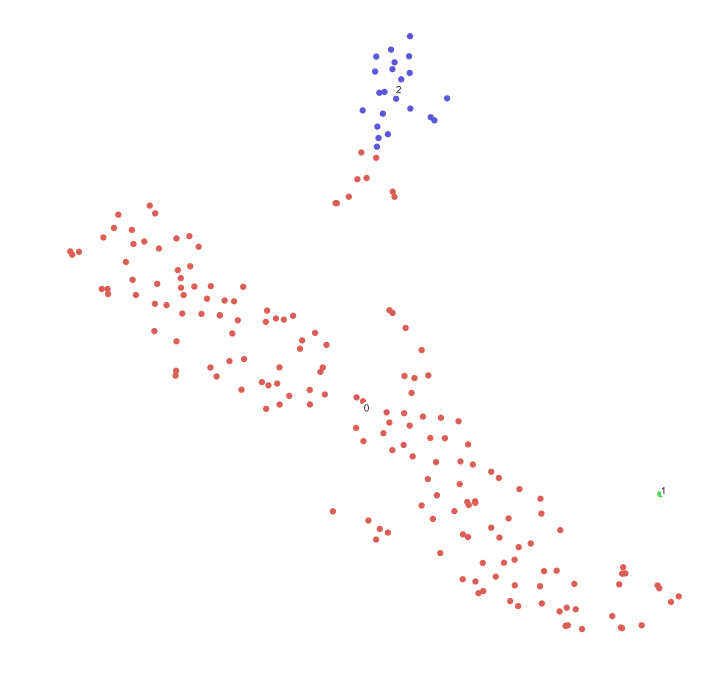

In [10]:
X_1 = logits['borrower'].detach().numpy()[index]
kmeans_1 = KMeans(n_clusters=3, random_state=0).fit(X_1)

PS1_1 = []
PS2_1 = []
PS3_1 = []

for i in list(zip(index,kmeans_1.labels_)):
    ind,ps = i
    if ps == 0:
        PS1_1.append(ind)
    elif ps == 1:
        PS2_1.append(ind)
    elif ps == 2:
        PS3_1.append(ind)
        
Psector1_rev_1 = np.array([0.,0.,0.,0.,0.])
Psector2_rev_1 = np.array([0.,0.,0.,0.,0.])
Psector3_rev_1 = np.array([0.,0.,0.,0.,0.])
n = 0
m = 0
p = 0
q = 0
for i in Final_Data_Set_Nor.items():
    ID,data = i
    if n in PS1_1:
        #print(data['Sector'],data['Revenue'],data['EBITDA'],data['NDE'],data['TDE'])
        Psector1_rev_1 += np.array(data['Revenue'])
        m += 1
    if n in PS2_1:
        #print(data['Sector'],data['Revenue'],data['EBITDA'],data['NDE'],data['TDE'])
        Psector2_rev_1 += np.array(data['Revenue'])
        p += 1
    if n in PS3_1:
        #print(data['Sector'],data['Revenue'],data['EBITDA'],data['NDE'],data['TDE'])
        Psector3_rev_1 += np.array(data['Revenue'])
        q += 1
           
    n += 1
    
Psector1_rev_1 = Psector1_rev_1/m
Psector2_rev_1 = Psector2_rev_1/p
Psector3_rev_1 = Psector3_rev_1/q
print(m,p,q)

plt.figure(figsize = (10,10))
S, = plt.plot(range(len(sector_rev_3)),sector_rev_3,'k')
ps1, = plt.plot(range(len(Psector1_rev_1)),Psector1_rev_1)
ps2, = plt.plot(range(len(Psector2_rev_1)),Psector2_rev_1)
ps3, = plt.plot(range(len(Psector3_rev_1)),Psector3_rev_1)
plt.legend([S,ps1,ps2,ps3],['325412 Sector', 'PS1', 'PS2', 'PS3'])
plt.title("325412 Sector")
plt.show()

fashion_tsne = TSNE(random_state=123).fit_transform(X_1)
fashion_scatter(fashion_tsne, kmeans_1.labels_)

118 91 74 756


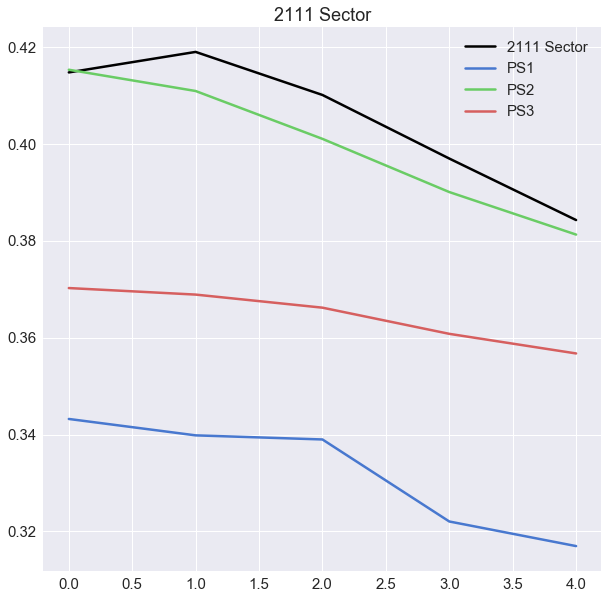

Avg Node Cluster Distance of Cluster  0  is  0.04154277
Cluster  0  Center  [-23.632751 -13.719597]
Avg Node Cluster Distance of Cluster  1  is  12.199862
Cluster  1  Center  [1.6607033 0.4990742]
Avg Node Cluster Distance of Cluster  2  is  1.4168959
Cluster  2  Center  [-24.091152 -10.128912]
1   29.01602
2   3.6198273
0   29.01602
2   27.85879
0   3.6198273
1   27.85879


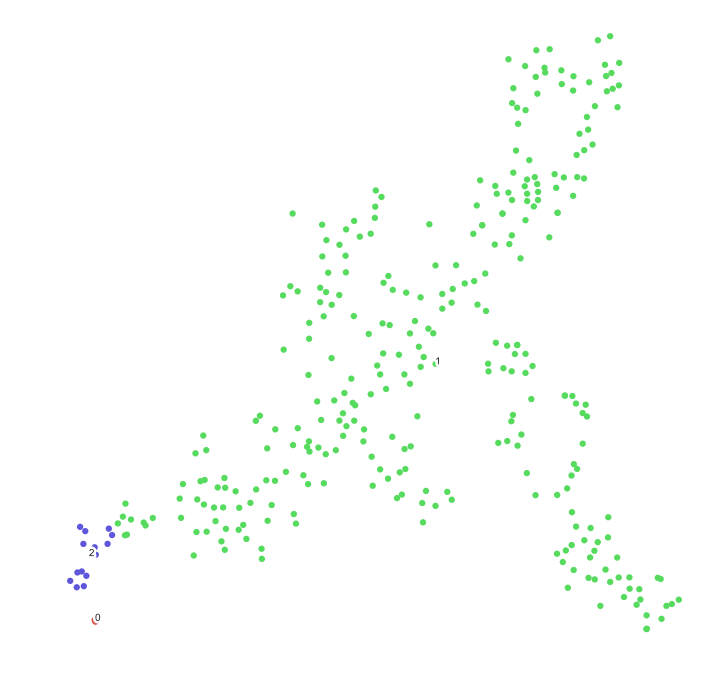

In [11]:
X_2 = logits['borrower'].detach().numpy()[index2]
kmeans_2 = KMeans(n_clusters=3, random_state=0).fit(X_2)

PS1_2 = []
PS2_2 = []
PS3_2 = []

for i in list(zip(index2,kmeans.labels_)):
    ind,ps = i
    if ps == 0:
        PS1_2.append(ind)
    elif ps == 1:
        PS2_2.append(ind)
    elif ps == 2:
        PS3_2.append(ind)
        
Psector1_rev_2 = np.array([0.,0.,0.,0.,0.])
Psector2_rev_2 = np.array([0.,0.,0.,0.,0.])
Psector3_rev_2 = np.array([0.,0.,0.,0.,0.])
n = 0
m = 0
p = 0
q = 0
for i in Final_Data_Set_Nor.items():
    ID,data = i
    if n in PS1_2:
        #print(data['Sector'],data['Revenue'],data['EBITDA'],data['NDE'],data['TDE'])
        Psector1_rev_2 += np.array(data['Revenue'])
        m += 1
    if n in PS2_2:
        Psector2_rev_2 += np.array(data['Revenue'])
        p += 1
    if n in PS3_2:
        Psector3_rev_2 += np.array(data['Revenue'])
        q += 1
           
    n += 1
    
Psector1_rev_2 = Psector1_rev_2/m
Psector2_rev_2 = Psector2_rev_2/p
Psector3_rev_2 = Psector3_rev_2/q
print(m,p,q,n)

plt.figure(figsize = (10,10))
S, = plt.plot(range(len(sector_rev_2)),sector_rev_2,'k')
ps1, = plt.plot(range(len(Psector1_rev_2)),Psector1_rev_2)
ps2, = plt.plot(range(len(Psector2_rev_2)),Psector2_rev_2)
ps3, = plt.plot(range(len(Psector3_rev_2)),Psector3_rev_2)
plt.legend([S,ps1,ps2,ps3],['2111 Sector', 'PS1', 'PS2', 'PS3'])
plt.title("2111 Sector")
plt.show()

fashion_tsne = TSNE(random_state=123).fit_transform(X_2)
fashion_scatter(fashion_tsne, kmeans_2.labels_)

89 70 49


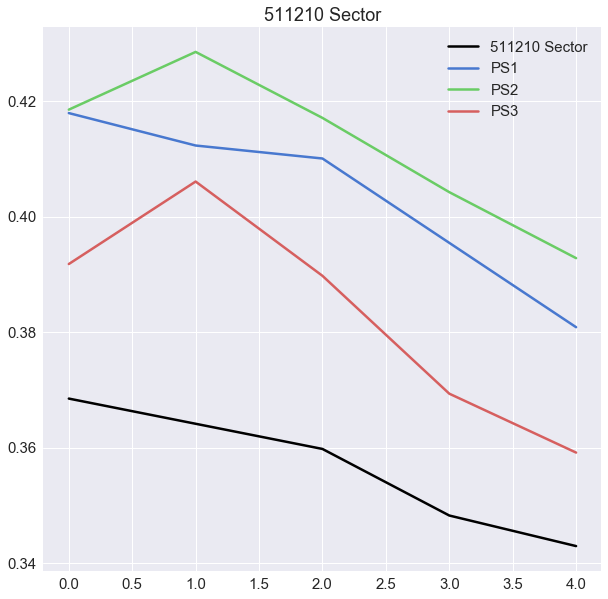

Avg Node Cluster Distance of Cluster  0  is  9.881388
Cluster  0  Center  [-1.3582822 -1.6820635]
Avg Node Cluster Distance of Cluster  1  is  0.47142503
Cluster  1  Center  [16.758966 10.448691]
Avg Node Cluster Distance of Cluster  2  is  0.9435563
Cluster  2  Center  [14.052648 12.741247]
1   21.803438
2   21.10755
0   21.803438
2   3.546826
0   21.10755
1   3.546826


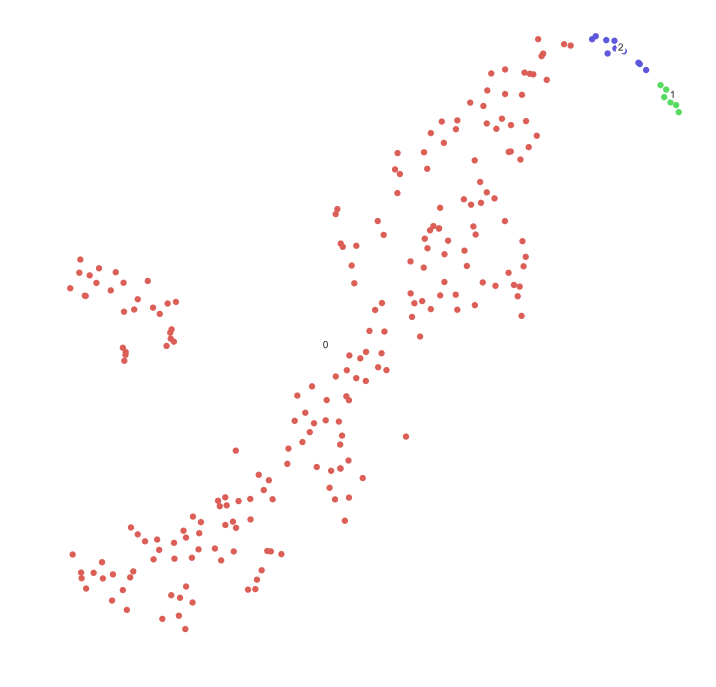

In [12]:
X_3 = logits['borrower'].detach().numpy()[index3]
kmeans_3 = KMeans(n_clusters=3, random_state=0).fit(X_3)

PS1_3 = []
PS2_3 = []
PS3_3 = []

for i in list(zip(index3,kmeans.labels_)):
    ind,ps = i
    if ps == 0:
        PS1_3.append(ind)
    elif ps == 1:
        PS2_3.append(ind)
    elif ps == 2:
        PS3_3.append(ind)
        
Psector1_rev_3 = np.array([0.,0.,0.,0.,0.])
Psector2_rev_3 = np.array([0.,0.,0.,0.,0.])
Psector3_rev_3 = np.array([0.,0.,0.,0.,0.])
n = 0
m = 0
p = 0
q = 0
for i in Final_Data_Set_Nor.items():
    ID,data = i
    if n in PS1_3:
        #print(data['Sector'],data['Revenue'],data['EBITDA'],data['NDE'],data['TDE'])
        Psector1_rev_3 += np.array(data['Revenue'])
        m += 1
    if n in PS2_3:
        Psector2_rev_3 += np.array(data['Revenue'])
        p += 1
    if n in PS3_3:
        Psector3_rev_3 += np.array(data['Revenue'])
        q += 1
           
    n += 1
    
Psector1_rev_3 = Psector1_rev_3/m
Psector2_rev_3 = Psector2_rev_3/p
Psector3_rev_3 = Psector3_rev_3/q
print(m,p,q)

plt.figure(figsize = (10,10))
S, = plt.plot(range(len(sector_rev_5)),sector_rev_5,'k')
ps1, = plt.plot(range(len(Psector1_rev_3)),Psector1_rev_3)
ps2, = plt.plot(range(len(Psector2_rev_3)),Psector2_rev_3)
ps3, = plt.plot(range(len(Psector3_rev_3)),Psector3_rev_3)
plt.legend([S,ps1,ps2,ps3],['511210 Sector', 'PS1', 'PS2', 'PS3'])
plt.title("511210 Sector")
plt.show()

fashion_tsne = TSNE(random_state=123).fit_transform(X_3)
fashion_scatter(fashion_tsne, kmeans_3.labels_)

In [13]:
g = dgl.heterograph({
    ('user', 'follows', 'user') : (T.tensor([0,1,2]),T.tensor([0,1,2])),
    ('user', 'plays', 'game') : (T.tensor([0,1,2]),T.tensor([0,1,2])),
    ('store', 'sells', 'game')  : (T.tensor([0,1,2]),T.tensor([0,1,2]))})

In [14]:
import dgl.nn.pytorch as dglnn
conv = dglnn.HeteroGraphConv({
    'follows' : dglnn.GraphConv(3,3, 'none', weight = False, bias = False),
    'plays' : dglnn.GraphConv(3,3, 'none', weight = False, bias = False),
    'sells' : dglnn.SAGEConv(3,3, 'mean', norm = None,weight = False, activation = None, bias = False)}, aggregate='sum')

TypeError: __init__() got an unexpected keyword argument 'weight'

In [ ]:
h1 = {'user' : T.rand(g.number_of_nodes('user'), 3), 'game' : T.ones(g.number_of_nodes('game'), 3)}
h11 = {'store' : T.rand(g.number_of_nodes('store'),3), 'game' : T.zeros(g.number_of_nodes('game'), 3)}
print(h1)
h2 = conv(g, h1)
print(h2)